In [67]:
import pandas as pd
import numpy as np
import numpy.typing as npt
import seaborn as sns
import matplotlib.pyplot as plt
import os

from dask.diagnostics import ProgressBar
import dask.dataframe as dd

In [2]:
PROJECT_PATH = '/root/autodl-tmp'
DATA_PRO = 'data/processed'
PROBLEMS = "qc23_prob.csv"
PA_MAPPING = 'problem_assistment_mapping.csv'
RESPONSE_COUNT = 'problem_response_counts.csv'

In [3]:
df = pd.read_csv(os.path.join(PROJECT_PATH, DATA_PRO, PROBLEMS))
pa_df = pd.read_csv(os.path.join(PROJECT_PATH, DATA_PRO, PA_MAPPING))
response_df = pd.read_csv(os.path.join(PROJECT_PATH, DATA_PRO, RESPONSE_COUNT))

In [35]:
# filter out rows where problem_body is null
df = df[df['problem_body'].notna()]

In [55]:
# counts number of problems that have response_count = 1
ans_1 = len(df[df['response_count'] == 1])
# counts number of problems that have response_count between 2-10
ans_10 = len(df[(df['response_count'] > 2) & (df['response_count'] < 10)])
# counts number of problems that have response_count between 10-50
ans_50 = len(df[(df['response_count'] >= 10) & (df['response_count'] < 50)])
# counts number of problems that have response_count between 50-100
ans_100 = len(df[(df['response_count'] >= 50) & (df['response_count'] < 100)])
# counts number of problems that have response_count between 100-200
ans_200 = len(df[(df['response_count'] >= 100) & (df['response_count'] < 200)])
# counts number of problems that have response_count between 200-500
ans_500 = len(df[(df['response_count'] >= 200) & (df['response_count'] < 500)])
# counts number of problems that have response_count between 500-1000
ans_1000 = len(df[(df['response_count'] >= 500) & (df['response_count'] < 1000)])
# counts number of problems that have response_count more than 1000
ans_1000_plus = len(df[df['response_count'] >= 1000])

ans_count = pd.Series([ans_1, ans_10, ans_50, ans_100, ans_200, ans_500, ans_1000, ans_1000_plus], index=['1', '2-10', '10-50', '50-100', '100-200', '200-500', '500-1000', '1000+'])
ans_count

1            277
2-10        2598
10-50       9291
50-100      4780
100-200     5005
200-500     6264
500-1000    4200
1000+       9350
dtype: int64

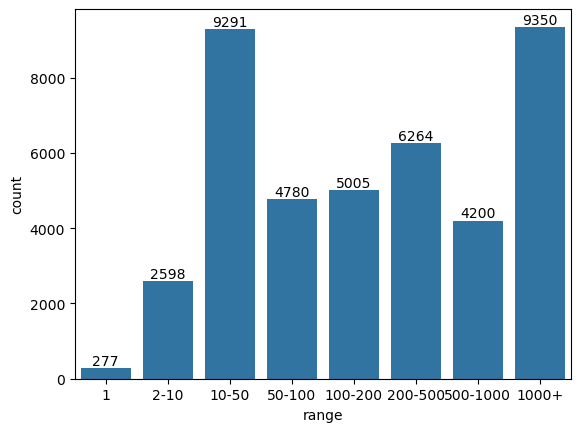

In [ ]:
# Convert Series to DataFrame for seaborn plotting
ans_count_df = pd.DataFrame({'count': ans_count.values, 'range': ans_count.index})
sns.barplot(data=ans_count_df, x='range', y='count')
# label each bar with the count
for index, row in ans_count_df.iterrows():
    plt.text(row['range'], row['count'], row['count'], ha='center', va='bottom')
plt.show()


In [ ]:
df

In [5]:
# Check if the number of unique problem_id and assistment_id are the same
print(df['problem_id'].nunique() == pa_df['problem_id'].nunique())
print(df['assistment_id'].nunique() == pa_df['assistment_id'].nunique())

# Check if the number of rows are the same
print(len(df) == len(pa_df))

True
True
True


In [10]:
# Check problem_id to assistment_id mapping
problem_to_assistment = df.groupby('problem_id')['assistment_id'].nunique()
multiple_assistments = problem_to_assistment[problem_to_assistment > 1]

# Check assistment_id to problem_id mapping
assistment_to_problem = df.groupby('assistment_id')['problem_id'].nunique()
multiple_problems = assistment_to_problem[assistment_to_problem > 1]

if multiple_assistments.empty:
    print('Every problem is mapped to a single assistment')
else:
    print('Multiple assistments are mapped to the same problem')
    print(multiple_assistments)
print('\n')
if multiple_problems.empty:
    print('Each assistment is mapped to a single problem')
else:
    print('Multiple problems are mapped to the same assistment')
    print('Out of %d assisments, %d contains multiple problems' % (df['assistment_id'].nunique(), len(multiple_problems)))

Every problem is mapped to a single assistment


Multiple problems are mapped to the same assistment
Out of 18362 assisments, 11151 contains multiple problems


In [70]:
assist_prob_count = df.groupby('assistment_id', as_index=False)['problem_id'].count().rename(columns={'problem_id': 'problem_count'}).sort_values('problem_count', ascending=False).reset_index(drop=True)

In [72]:
assist_prob_count

assistment_id  problem_count
0             920573             30
1             844426             27
2            1029345             26
3             843786             25
4            1014810             25
...              ...            ...
18357        1415521              1
18358        1415536              1
18359        1415537              1
18360        1415538              1
18361        1415539              1

[18362 rows x 2 columns]

#### Text Cleaning

In [21]:
import re
import unicodedata
import pprint 

from bs4 import BeautifulSoup

In [27]:
def soup_remove_style_span(soup):
    """
    Given a html soup, get rid of the source credit.
    """
    # 
    footnote_span = soup.find_all('span', style = "font-size: 8pt;")
    if footnote_span is not None:
        for span in footnote_span:
            span.decompose()
    
    return soup

def soup_remove_url_parent(soup):
    """
    Get rid of the Source credit footter
    one example: 
    </p><p style="font-size: 10px; text-align: right">\r\n    Modified from <a href="https://www.engageny.org/" target="_blank">EngageNY</a> &copy;Great Minds <a href="https://new.assistments.org/curricula/great-minds" target="_blank">Disclaimer</a>
    """
    [a.parent.decompose() for a in soup.find_all('a') if (parent := a.parent)]
    return soup

def remove_html(content):
    """
    remove html elements.
    """
    soup = BeautifulSoup(content, 'html.parser')

    soup = soup_remove_style_span(soup)
    soup = soup_remove_url_parent(soup)
    text = soup.get_text(' ', strip=True)
    return unicodedata.normalize('NFKD', text) 


def identify_type(content):
    """
    Given a html string, classify it as 'PIX' or 'TXT depending on whether there is a 'img' class in the content.

    >>> type = identify_type(" <p><img src="/images/assistments/93900.jpg" alt="" width="134" height="49" /></p>")
    >>> type
    >>> 'PIX'
    """
    img_obj = BeautifulSoup(content, 'html.parser').find('img')
    if img_obj is not None:
        return 'PIX'
    else:
        return 'TXT'

def remove_newline(text):
    """
    given a string remove new line
    """
    return text.replace("\r\n", " ").replace("\n", " ")

In [28]:
def clean_text(content):
    text = remove_html(content)
    text = remove_newline(text)
    return text


In [37]:
# Construct two features of problem body text and body type
df['body_text'] = df['problem_body'].apply(clean_text)
df['body_type'] = df['problem_body'].apply(identify_type)

/tmp/ipykernel_2504/3325977049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['body_text'] = df['problem_body'].apply(clean_text)
/tmp/ipykernel_2504/3325977049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['body_type'] = df['problem_body'].apply(identify_type)


In [38]:
df

problem_id  assistment_id         problem_type  problem_type_id  \
0         1227723         838896              algebra               17   
1         1438787         839859  fill_in_ignore_case               11   
2         1459661        1027691              numeric               13   
3         1660259        1168981             choose_1                1   
4         1228312         840035             choose_1                1   
...           ...            ...                  ...              ...   
44404     1903298        1325883  fill_in_ignore_case               11   
44405     1799592        1262874        open_response                8   
44406     1662603        1170887              numeric               13   
44407     1794945        1263006        open_response                8   
44408     1794959        1263006        open_response                8   

                                            problem_body  response_count  \
0      <p>If Suellen has been taking dance lessons fo...            2886   
1      <p>Use your expression to determine how much M...            2204   
2      <p>If Suzannah&rsquo;s budget limit is $10 per...            6240   
3                                     <p>Page 353 #6</p>              70   
4      <p>Substitute the value for the variable, and ...            3066   
...                                                  ...             ...   
44404  <p>Let 𝑓 be the function defined by&nbsp;<img ...               1   
44405                      <p>Justify your thinking.</p>               1   
44406  <p>Page 547 #7</p>\n<p>What is the number of s...               1   
44407                                     <p>Part f)</p>               1   
44408                                     <p>Part j)</p>               1   

                                               body_text body_type  
0      If Suellen has been taking dance lessons for y...       TXT  
1      Use your expression to determine how much Mr. ...       TXT  
2      If Suzannah’s budget limit is $10 per month, h...       TXT  
3                                            Page 353 #6       TXT  
4      Substitute the value for the variable, and sta...       PIX  
...                                                  ...       ...  
44404  Let f be the function defined by for all real ...       PIX  
44405                             Justify your thinking.       TXT  
44406  Page 547 #7 What is the number of students who...       TXT  
44407                                            Part f)       TXT  
44408                                            Part j)       TXT  

[44405 rows x 8 columns]

In [47]:
# create a new dataframe that contains assistment_id, problem_id, problem_type, problem_body
assistment = df[['assistment_id', 'problem_id', 'problem_type', 'body_text', 'body_type']].sort_values('assistment_id').reset_index(drop=True)

# create a new column that concates problem_id and problem_body
assistment['assistment_body'] = assistment['problem_id'].astype(str) + ' ' + assistment['body_type'] + ' ' + assistment['problem_type'] + ' - ' + assistment['body_text']

# groupby assistment_id, sort by problem_id in ascending order, and then concatenate problem_id_body under each assistment_id
assistment = assistment.groupby('assistment_id').apply(lambda x: x.sort_values('problem_id').assign(assistment_body=lambda y: y['assistment_body'].str.cat(sep='\n'))).reset_index(drop=True)
# one assistment per row
assistment = assistment.drop_duplicates(subset=['assistment_id']).reset_index(drop=True)
assistment

/tmp/ipykernel_2504/2595727878.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  assistment = assistment.groupby('assistment_id').apply(lambda x: x.sort_values('problem_id').assign(assistment_body=lambda y: y['assistment_body'].str.cat(sep='\n'))).reset_index(drop=True)


assistment_id  problem_id   problem_type  \
0              30446       43962        numeric   
1              30613       44636  open_response   
2              30772       44924    old_algebra   
3              30893       45418  open_response   
4              30898       45441       choose_1   
...              ...         ...            ...   
18357        1421239     2071350        algebra   
18358        1421240     2071362       choose_1   
18359        1421241     2071372        algebra   
18360        1421242     2071380        numeric   
18361        1421243     2071386       choose_1   

                                               body_text body_type  \
0      At the end of every 2nd mile of the Boston Mar...       TXT   
1      A scale drawing of a courtyard in the shape of...       PIX   
2      a. ON YOUR PAPER Construct a stem-and-leaf plo...       PIX   
3      John is playing a board game that uses a pair ...       PIX   
4      a. Did the 30th customer receive a free cookie...       TXT   
...                                                  ...       ...   
18357   Solve for x in the equation below. x = _________       PIX   
18358  Solve for x in the inequality below. Choose th...       PIX   
18359   Solve for x in the equation below. x = _________       PIX   
18360                 Solve for x in the equation below.       PIX   
18361  Solve for x in the inequality below. Choose th...       PIX   

                                         assistment_body  
0      43962 TXT numeric - At the end of every 2nd mi...  
1      44636 PIX open_response - A scale drawing of a...  
2      44924 PIX old_algebra - a. ON YOUR PAPER Const...  
3      45418 PIX open_response - John is playing a bo...  
4      45441 TXT choose_1 - a. Did the 30th customer ...  
...                                                  ...  
18357  2071350 PIX algebra - Solve for x in the equat...  
18358  2071362 PIX choose_1 - Solve for x in the ineq...  
18359  2071372 PIX algebra - Solve for x in the equat...  
18360  2071380 PIX numeric - Solve for x in the equat...  
18361  2071386 PIX choose_1 - Solve for x in the ineq...  

[18362 rows x 6 columns]

In [48]:
for index, (id, body) in enumerate(zip(assistment['assistment_id'].to_numpy(), assistment['assistment_body'].to_numpy())):
    print(index)
    print("Assistment ID: ", id)  # print the body without truncation
    print("Assistment Body: ", body)
    print('\n')


0
Assistment ID:  30446
Assistment Body:  43962 TXT numeric - At the end of every 2nd mile of the Boston Marathon, a typical marathon runner takes about 4 ounces of water. At this rate, how many ounces of water would an average runner take in an entire 26.2 mile marathon? Do not include units (ounces) in your answer.
43964 TXT numeric - At this rate, about how many pints of water would an average runner take in an entire 26.2-mile marathon? (1 pint = 16 ounces) Do not include units (pints) in your answer.


1
Assistment ID:  30613
Assistment Body:  44636 PIX open_response - A scale drawing of a courtyard in the shape of a hexagon is shown on the grid below.The coordinates of 3 vertices of the hexagon are given. a. The courtyard has a vertical line of symmetry. What are the coordinates of the other 3 vertices of the hexagon?
44638 TXT old_algebra - b. If the courtyard is to be fenced on all sides, how many yards of fencing will be required?
44644 TXT old_algebra - c. A fish pond will co